### Imports

In [98]:
import scipy as sci
from scipy import stats
from scipy.special import expit
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
%matplotlib widget


### Read Data

In [99]:
file = 'Iris.csv'
data = pd.read_csv(file, index_col=0, header=0).reset_index(drop=True)
N_S = len(data.index)
indices = data.index

### Preprocess

In [100]:
X_S, Y_S = data.iloc[:, :-1], data.iloc[:, -1]

def normalize(points):
    min = points.min(axis=0)
    scale = points.max(axis=0) - min
    def denormalize(points):
        return points * scale + min
    return (points - min) / scale, denormalize

X_S, denormalize = normalize(X_S)

def label_to_int(data):
    labels = data.unique()
    label_map = dict(zip(labels, range(len(labels))))
    return data.apply(lambda x: label_map[x]), labels

Y_S, labels = label_to_int(Y_S)

### Learner measures

In [101]:
# lower bound to sample size
def PAC_eta(H_norm, delta, epsilon):
    return (np.ln(H_norm) - np.ln(delta))/epsilon

# lower bound to generalization error
def PAC_delta(H_norm, epsilon, eta):
    return H_norm/np.exp(eta*epsilon)


# Sampling

### Sampling Distributions

Text(0.5, 0, 'Sample Index')

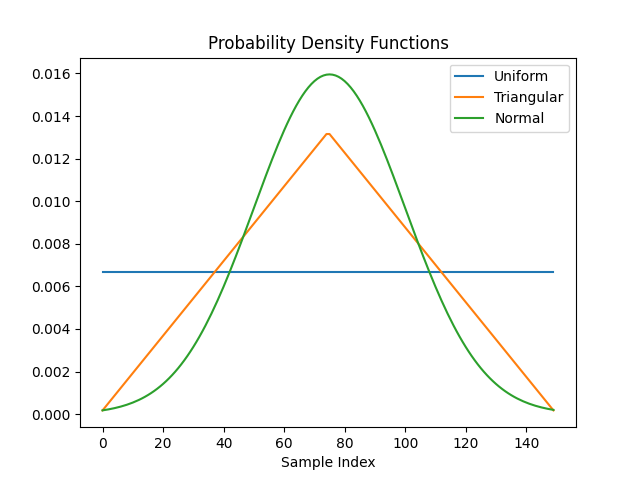

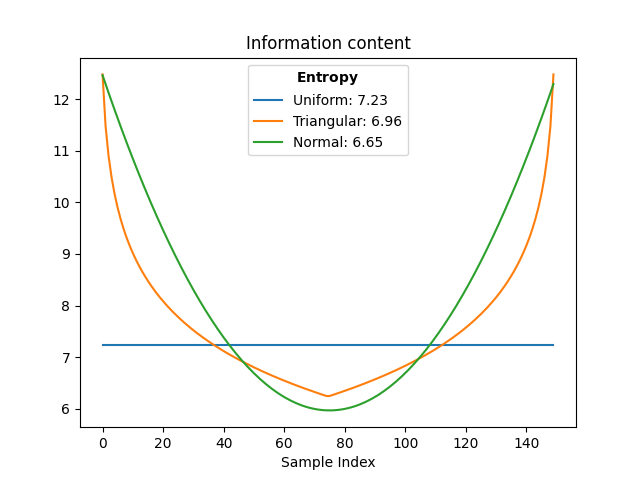

In [102]:
def pdf(pdf, x, N): return pd.Series({
    "Uniform": sci.stats.uniform.pdf(x, 0, N),
    "Triangular": sci.stats.triang.pdf(x, 0.5, -1, N+1),
    "Normal": sci.stats.norm.pdf(x, N//2, N//6)}[pdf], index=x)

plt.figure()
pdf_names = ["Uniform", "Triangular", "Normal"]
for name in pdf_names:
    F = pdf(name, indices, N_S)
    plt.plot(indices, F, label=name)
plt.legend()
plt.title("Probability Density Functions")
plt.xlabel("Sample Index")

plt.figure()
for name in pdf_names:
    F = pdf(name, indices, N_S)
    I = np.log2(1/F)
    H = np.sum(-F*np.log2(F))
    plt.plot(indices, I, label=f"{name}: {H:.2f}")
plt.legend(title="$\\bf{Entropy}$")
plt.title("Information content")
plt.xlabel("Sample Index")

### Comparison of samples

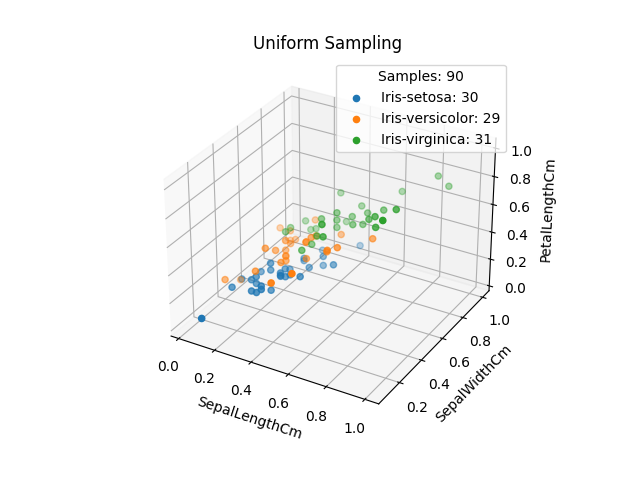

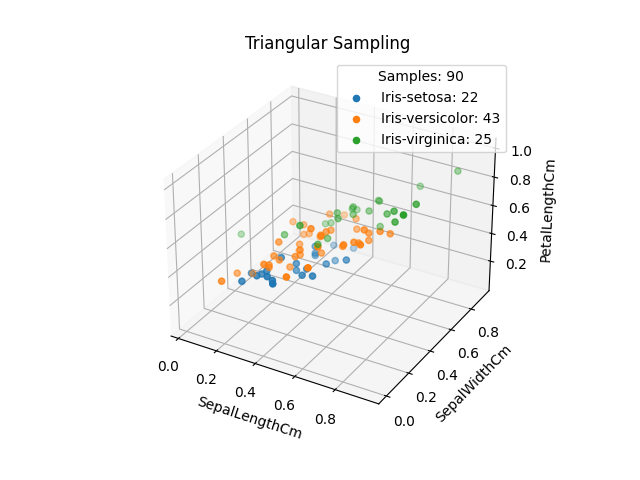

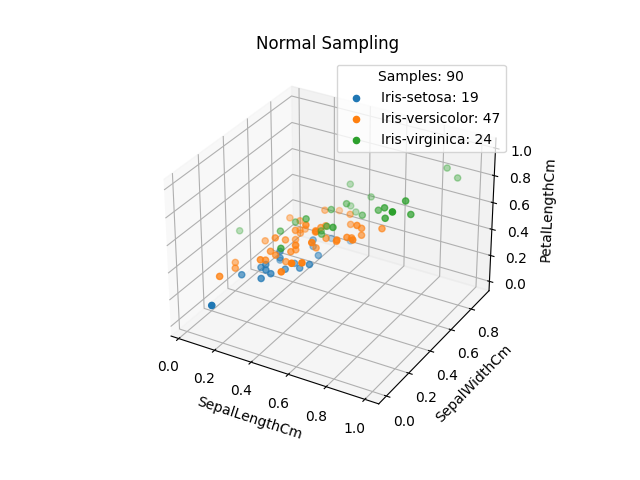

In [103]:
def set_axis_labels(ax, x, y, z):
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)

for name in pdf_names:
    plt.figure()
    ax = plt.axes(projection='3d', title=f"{name} Sampling")
    sample = Y_S.sample(frac=0.6, weights=pdf(name, indices, N_S))
    total = 0
    for (k, v) in enumerate(labels):
        matches = (sample == k).reindex(indices, fill_value=False)
        total += np.sum(matches)
        points = X_S[matches]
        ax.scatter(*zip(*points.iloc[:, 0:3].values.tolist()),
                   label=f"{v}: {len(points)}")
    plt.legend(title=f"Samples: {total}")
    set_axis_labels(ax, *points.columns[0:3])


# Training

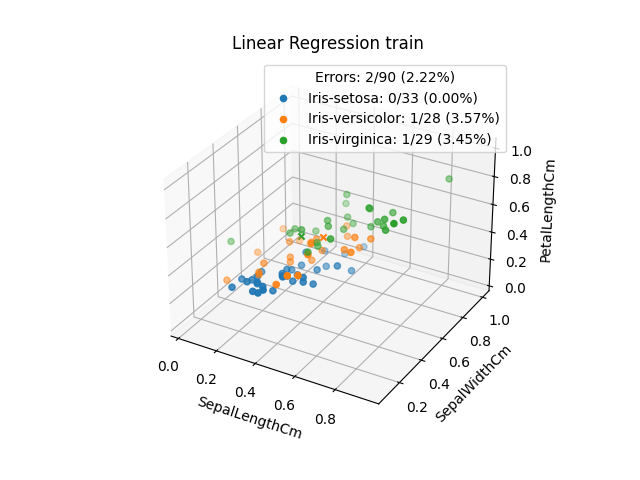

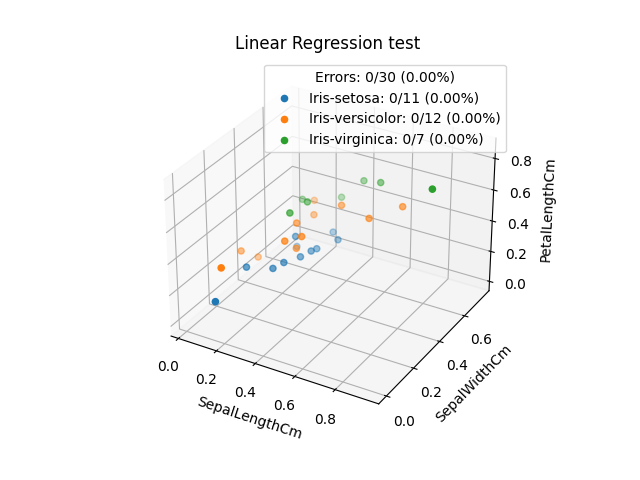

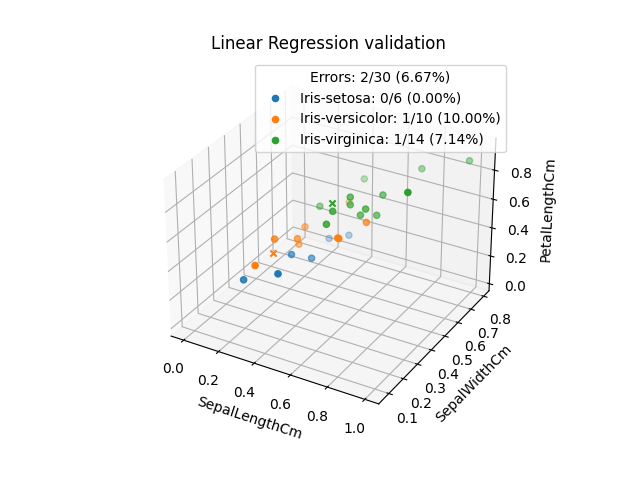

In [104]:
# gets B such that ||Y-XB||^2 is minimized
def linear_regression(X, Y):
    # Adds a 1s column to X to represent a constant parameter
    X = np.append(X, np.ones((X.shape[0], 1)), axis=1)
    Beta = np.asmatrix(X.T @ X).I @ X.T @ Y
    return Beta


weights = pdf("Uniform", indices, N_S)
sets = {"train": int(0.6*N_S), 
        "test": int(0.2*N_S),
        "validation": int(0.2*N_S)}

for k, v in sets.items():
    Y = Y_S[weights.index].sample(n=v, weights=weights)
    sets[k] = (X_S.iloc[Y.index, :], Y)
    weights = weights.drop(Y.index)

X, Y = sets["train"]

Beta = linear_regression(X, Y)

for k in sets:
    X, Y = sets[k]
    X = X.copy()
    X["ones"] = np.ones(X.shape[0])
    Z = np.round(X @ Beta)

    plt.figure()
    ax = plt.axes(projection='3d', title=f"Linear Regression {k}")
    TP_total = 0
    FP_total = 0

    error_str = lambda T, F: f"{F}/{F+T} ({F/(F+T):.2%})"
    for (k, v) in enumerate(labels):
        TP = (Z == k) & (Y == k)
        TP_sum = np.sum(TP)
        TP_total += TP_sum
        FP = (Z == k) & (Y != k)
        FP_sum = np.sum(FP)
        FP_total += FP_sum

        color = ax._get_lines.get_next_color()
        if TP_sum > 0:
            ax.scatter(*zip(*X[TP].iloc[:,0:3].values),
                    label=f"{v}: {error_str(TP_sum, FP_sum)}", color=color)
        if FP_sum > 0:
            ax.scatter(*zip(*X[FP].iloc[:, 0:3].values.tolist()), marker="x", color=color)
    plt.legend(title=f"Errors: {error_str(TP_total, FP_total)}")
    set_axis_labels(ax, *X.columns[0:3])


### Neural Network

77     1
26     0
129    2
30     0
82     1
      ..
106    2
43     0
55     1
56     1
142    2
Name: Species, Length: 90, dtype: int64
[[7.41059000e-03 9.84409864e-01 7.36525479e-03 9.81457029e-01
  1.61043958e-02 9.91935390e-01 9.91459206e-01 1.47436114e-02
  9.91724044e-01 2.91863227e-03 9.88241074e-01 3.18437913e-03
  9.70285151e-01 6.83670061e-03 2.90025834e-02 9.90630045e-01
  5.50603798e-03 9.67909723e-01 5.12294178e-03 1.39539883e-02
  9.95557657e-01 9.92563241e-01 9.86221337e-01 9.83943030e-01
  1.11363679e-02 9.91379251e-01 9.88540094e-01 9.93338543e-01
  1.06174370e-02 1.49198166e-02 9.83143438e-01 3.43719424e-03
  9.71775783e-01 9.61847132e-03 9.82834482e-01 1.37013740e-02
  9.87975881e-01 5.10064541e-03 5.02875881e-03 3.23161667e-03
  4.29522068e-03 3.53762439e-03 5.36951893e-03 1.55996277e-02
  1.86368165e-02 4.47108246e-03 9.86452570e-01 7.84551131e-03
  1.48830713e-02 9.95425443e-01 9.21108881e-03 3.89196261e-03
  1.01415585e-02 6.47603611e-03 9.90599732e-01 1.669292

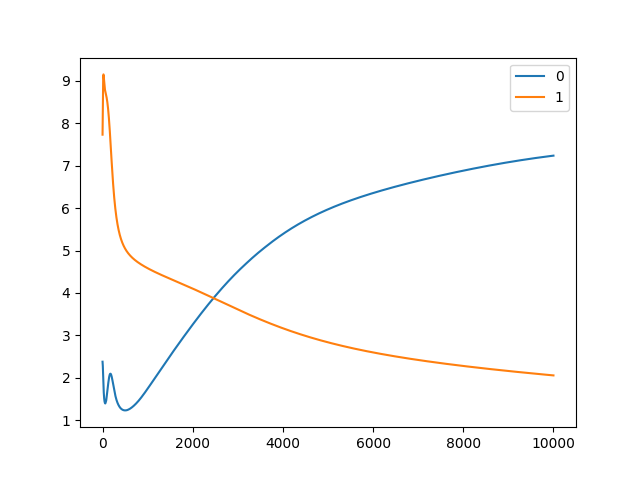

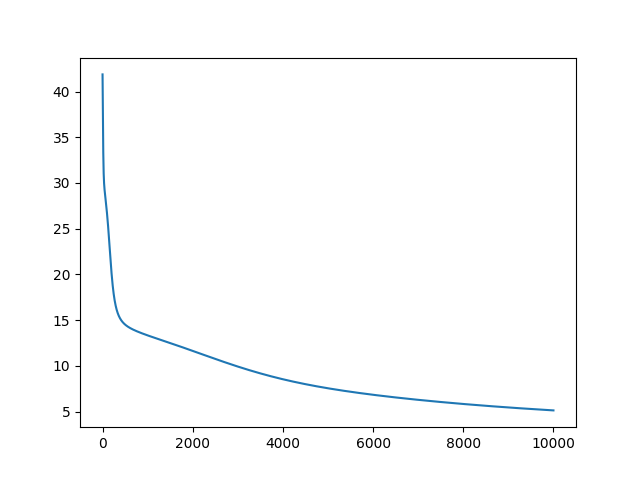

In [175]:
def to_vector(Y, cats):
    id = np.identity(cats)
    return np.array([id[c, :] for c in Y])
    
def sequential(X, Yd, W, phi, dphi):
    p = X.shape[1]

    # feedforward
    V = [None] * (k+1)
    Y = [None] * (k+1)
    Y[0] = X
    for l in range(1, k+1):
        V[l] = W[l] @ Y[l-1]
        Y[l] = phi(V[l])
    softmax = lambda x: np.exp(x) / sum(np.exp(x))
    dsoftmax = lambda x: np.diag(softmax(x).flatten()) @ (np.eye(x.shape[0]) - softmax(x))
    #Y[k] = softmax(V[k])

    # backpropagation
    dE = Y[k] - Yd
    E = np.diag((Y[k] - Yd).T @ (Y[k] - Yd))/2

    delta = [None] * (k+1)
    delta[k] = dE * dphi(V[k])
    #delta[k] = np.column_stack([dsoftmax(V[k][:, [c]]) @ dE[:, [c]] for c in range(p)])
    for l in reversed(range(1, k)):
        delta[l] = (W[l+1].T @ delta[l+1]) * dphi(V[l])

    # update
    for l in range(1, k+1):
        W[l] -= (delta[l] @ Y[l-1].T) / p
    return W, delta, E


# X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]).T
# Yd = np.array([[0, 0, 0], [0, 1, 1], [0, 1, 1], [1, 1, 0]]).T
X, Y = sets["train"]
X, Yd = X.to_numpy().T, to_vector(Y, 3).T
neurons = [len(X), 3, len(Yd)]
k = len(neurons) - 1
W = [None] * (k+1)
for l in range(1, k+1):
    W[l] = np.random.randn(neurons[l], neurons[l-1])

phi = expit
dphi = lambda x: phi(x) * (1 - phi(x))
#phi = lambda x: x
#dphi = lambda x: np.ones(x.shape)

deltas = []
errors = []
epochs = 10000
for i in range(epochs):
    W, b, E = sequential(X, Yd, W, phi, dphi)
    deltas.append([np.mean(sum(np.abs(b[l].T))) for l in range(1, k+1)])
    errors.append(sum(E))
    Y_last = X
for l in range(1, k+1):
    V_last = W[l] @ Y_last
    Y_last = phi(V_last)
print(Y_last)
print(np.round(Y_last))
deltas = np.array(deltas).T
plt.figure()
plt.plot(range(epochs), deltas.T)
plt.legend(range(deltas.shape[0]))
plt.figure()
plt.plot(range(epochs), errors)
